<a href="https://colab.research.google.com/github/quentinproject/SpeechRecognition/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.1 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149863 sha256=8c0f0fc8ff75d8481700edd8d11a84de4dcdf7430fe66467faae3c50fd4a14af
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#librairies

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
#base de donnees pour entrainement du modele

data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path=keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

#localisation sur colab :  """./root/.keras/datasets/LJSpeech-1.1"""

#lecture du fichier metadata et analyse de celui-ci

metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)


,file_name,normalized_transcription
0,LJ038-0286,when combined with the other testimony linking...
1,LJ004-0086,"of ""poor and needy prisoners committed to the ..."
2,LJ017-0162,Whatever the exact cause which impelled him to...


In [ ]:
#separation des donnees

split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")


Size of the training set: 11790
Size of the training set: 1310


In [ ]:
# l'ensemble des caractères compris dans la transcription

characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

# conversion en nombre entier

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

# conversion des entiers en caractères originaux

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [ ]:
# Tensor scalaire entier. Longueur de la fenêtre en échantillons.
frame_length = 256
# Tensor scalaire entier. Nombre d'échantillons par étape.
frame_step = 160
# Tensor scalaire entier. Taille du FFT à appliquer.
fft_length = 256


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Traite l'audio
    ##########################################
    # 1. Lecture fichier wav
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode fichier wav
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change le type à flottant
    audio = tf.cast(audio, tf.float32)
    # 4. Obtient le spectrogramme
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. Amplitude
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. Normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Traite le label
    ##########################################
    # 7. Converti label à Lower case
    label = tf.strings.lower(label)
    # 8. Sépare le label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map les caracteres dans label a des nombres
    label = char_to_num(label)
    # 10. Renvoie les 2 entrees du modele
    return spectrogram, label

In [ ]:
batch_size = 32
# Defini le jeu d'entrainement
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Defini le jeu de validation
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

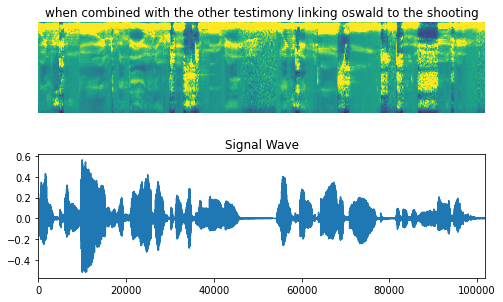

In [ ]:
# Affiche un audio, son spectre et son signal.
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogramme
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=3, rnn_units=128):
    """Model similar to DeepSpeech2."""

    # entree du modele
    input_spectrogram = layers.Input((None, input_dim), name="input")

    # etend la dimension pour utiliser 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
        )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)

    x = layers.BatchNormalization(name="conv_2_bn")(x)

    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape the resulted volume to feed the RNNs layers

    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers

    for i in range(1,rnn_layers+1):
      recurrent = layers.GRU(
          units=rnn_units,
          activation="tanh",
          recurrent_activation="sigmoid",
          use_bias=True,
          return_sequences=True,
          reset_after=True,
          name=f"gru_{i}",
          )

      if i < rnn_layers:
          x = layers.Dropout(rate=0.5)(x)

    x = tf.keras.layers.Bidirectional(
        recurrent, name=f"bidirectional_{i}", merge_mode="concat", backward_layer=None,weights=None
        )(x)

    # Dense layer

    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model

    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")

    # Optimizer

    opt = keras.optimizers.Adam(learning_rate=0.0001)

    # Compilation du modele et retour

    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Obtention du modele

model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=3000,
)

model.summary(line_length=110)



Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 129)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 129, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 65, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 65, 32)                     

In [ ]:
# Fonction d'utilite pour decoder la sortie du reseau.


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # On utilise greedy search. (marche aussi avec beam search).

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    # Itere les resultats et recupere le texte.

    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# classe de rappel pour produire des transcriptions pendant l'entraînement.

class CallbackEval(keras.callbacks.Callback):

    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []

        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)

        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [ ]:
# Definit le nombre d'epochs.

epochs = 5

# Fonction de rappel pour vérifier la transcription sur le jeu de valeurs.

validation_callback = CallbackEval(validation_dataset)

# Entrainement du model.

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

print("Fin de l'entrainement du modele")



In [ ]:
#sauvegarde du modele.

#model.save('/path/')

model.save('./drive/MyDrive/Colab/model/modele_f50.h5')

print("Le modele est sauvegarde")


Le modele est sauvegarde


In [ ]:
#charger un modele sauvegarde.

#save_format="h5"

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab/model/modele_f50.h5',compile=False)

#optimisation

opt = keras.optimizers.Adam(learning_rate=0.0001)

#compilation

model.compile(optimizer=opt, loss=CTCLoss)

print("model charge et compile")


model charge et compile


In [ ]:
# Base de donnees pour evaluation du modele

data_eval_path="/content/drive/MyDrive/Colab/data_eval"
wavs_path=data_eval_path + "/wavs_eval/"
metadata_eval_path = data_eval_path + "/metadata_eval.csv"

# Read metadata file and parse it

metadata_eval_df = pd.read_csv(metadata_eval_path , sep="|", header=None, quoting=3)
metadata_eval_df.columns = ["file_name", "transcription"]
metadata_eval_df = metadata_eval_df[["file_name", "transcription"]]
metadata_eval_df = metadata_eval_df.sample(frac=1).reset_index(drop=True)
metadata_eval_df.head(3)


,file_name,transcription
0,Audio 2,Ceci est un test en Francais
1,Audio 1,This is an evaluation sample to know if the mo...


In [ ]:

split = int(len(metadata_eval_df) * 0.90)
df_train = metadata_eval_df[split:]


print(f"Size of the training set: {len(df_train)}")


Size of the training set: 1


In [ ]:
batch_size = 32

eval_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["transcription"]))
)
eval_dataset = (
    eval_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

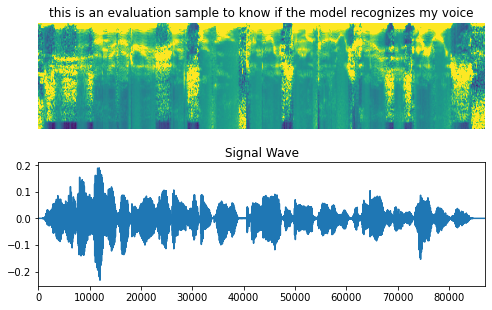

In [ ]:
# Affichage audio evalue

fig = plt.figure(figsize=(8, 5))

for batch in eval_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0]+".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [ ]:
# Resultats
predictions = []
targets = []
for batch in eval_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9231
----------------------------------------------------------------------------------------------------
Target    : this is an evaluation sample to know if the model recognizes my voice
Prediction: eit an a ianhenton o coerto hn her e
----------------------------------------------------------------------------------------------------
Target    : this is an evaluation sample to know if the model recognizes my voice
Prediction: eit an a ianhenton o coerto hn her e
----------------------------------------------------------------------------------------------------
Target    : this is an evaluation sample to know if the model recognizes my voice
Prediction: eit an a ianhenton o coerto hn her e
----------------------------------------------------------------------------------------------------
Target    : this is an evaluation sample to know if the model recognizes my vo